# David Ogaus, Jonathan Caspar, Tommy Côté et Xiuli Zhang 
## IFT 3700
## 6 Novembre 2018
## Travail 1

## Mesure de similarité
ON va mettre ici notre description de la mesure de similarité

In [15]:
# La métrique euclidienne
def metric_euclid(x, y):
    sum=0
    for i in range(len(x)):
        sum += (x[i]-y[i])**2
    return math.sqrt(sum)

# La métrique #1 dans le fichier word
def metric_n1(x, y):
    sum_x=0
    sum_y=0
    for i in range(len(x)):
        sum_x += x[i]
        sum_y += y[i]
    return abs(sum_x - sum_y)

# La métrique #3 dans le fichier word
def metric_n3(x, y):
    sum=0
    for i in range(len(x)):
        if ((x[i]==0 and y[i]==0) or (x[i]!=0 and y[i]!=0)):
            sum+=1
    return 1 - sum/(len(x))



## Importation du jeu de données MNIST

In [16]:
import csv
import random
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import silhouette_score
from sklearn.metrics import accuracy_score
from sklearn.decomposition import KernelPCA
from sklearn.datasets import load_digits
from sklearn.preprocessing import scale
from sklearn import neighbors

#On ouvre le fichier 'mnist_train.csv'
data = open('mnist_train.csv')
csv_file = csv.reader(data)
data_points = []
for row in csv_file:
    data_points.append(row)
data.close()

#On enlève la première ligne, soit les "headers" de nos colonnes
data_points.pop(0)

#On transforme les données en integers
for i in range(len(data_points)):
    for j in range(0,785):
            data_points[i][j] = int(data_points[i][j])

#Vecteur 60 000 x 1 qui contient les étiquettes
y_train = []
for row in data_points:
    y_train.append(row[0])

#Matrice 60 000 x 784 qui contient les données
x_train = []
for row in data_points:
    x_train.append(row[1:785])
    
#On ouvre le fichier 'mnist_test.csv'
data = open('mnist_test.csv')
csv_file = csv.reader(data)
data_points = []
for row in csv_file:
    data_points.append(row)
data.close()

#On enlève la première ligne, soit les "headers" de nos colones
data_points.pop(0)

#Convertir en int
for i in range(len(data_points)):
    for j in range(0,785):
            data_points[i][j] = int(data_points[i][j])

#Vecteur 10 000 x 1 qui contient les étiquettes
y_test = []
for row in data_points:
    y_test.append(row[0])

#Matrice 10 000 x 784 qui contient les données
x_test = []
for row in data_points:
    x_test.append(row[1:785])

## Algorithme k-moyenne

In [17]:
# Crédit à https://github.com/salspaugh/machine_learning/blob/master/clustering/kmedoids.py
def k_medoid(distances, k=10):

    m = distances.shape[0] # number of points

    # Pick k random medoids.
    curr_medoids = np.array([-1]*k)
    while not len(np.unique(curr_medoids)) == k:
        curr_medoids = np.array([random.randint(0, m - 1) for _ in range(k)])
    old_medoids = np.array([-1]*k) # Doesn't matter what we initialize these to.
    new_medoids = np.array([-1]*k)

    # Until the medoids stop updating, do the following:
    while not ((old_medoids == curr_medoids).all()):
        # Assign each point to cluster with closest medoid.
        clusters = assign_points_to_clusters(curr_medoids, distances)

        # Update cluster medoids to be lowest cost point.
        for curr_medoid in curr_medoids:
            cluster = np.where(clusters == curr_medoid)[0]
            new_medoids[curr_medoids == curr_medoid] = compute_new_medoid(cluster, distances)

        old_medoids[:] = curr_medoids[:]
        curr_medoids[:] = new_medoids[:]

    return clusters

def assign_points_to_clusters(medoids, distances):
    distances_to_medoids = distances[:,medoids]
    clusters = medoids[np.argmin(distances_to_medoids, axis=1)]
    assert (clusters[medoids] == medoids).all()
    return clusters
    
def compute_new_medoid(cluster, distances):
    mask = np.ones(distances.shape)
    mask[np.ix_(cluster,cluster)] = 0.
    cluster_distances = np.ma.masked_array(data=distances, mask=mask, fill_value=10e9)
    costs = cluster_distances.sum(axis=1)
    return costs.argmin(axis=0, fill_value=10e9)

Text(0.5,1,'Score silhouette en fonction de k')

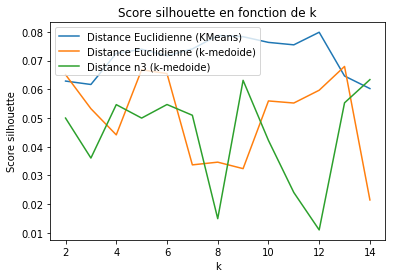

In [18]:
#Ensemble de donné réduit pour faire des tests
x__test= x_test[0:500]

# Définie une matrice des distances avec la métrique de notre choix
m_eucli = pairwise_distances(x__test, metric='euclidean')
m_n3 = pairwise_distances(x__test, metric=metric_n3)

scores = []
scores_t=[]
scores_n3=[]
k_range = range(2,15)
for k in k_range:
    y_pred = KMeans(n_clusters=k).fit_predict(x__test)
    scores.append(silhouette_score(x__test, y_pred))
    
    y_pred_t = k_medoid(m_eucli, k)
    scores_t.append(silhouette_score(x__test, y_pred_t))
    
    y_pred_n3 = k_medoid(m_n3, k)
    scores_n3.append(silhouette_score(x__test, y_pred_n3))

plt.plot(k_range, scores, label='Distance Euclidienne (KMeans)')
plt.plot(k_range, scores_t, label='Distance Euclidienne (k-medoide)')
plt.plot(k_range, scores_n3, label='Distance n3 (k-medoide)')
plt.legend(loc='upper left')
plt.xlabel('k')
plt.ylabel('Score silhouette')
plt.title('Score silhouette en fonction de k')

## KNN (Plus Proches Voisins)

0.925
1
0.875
1


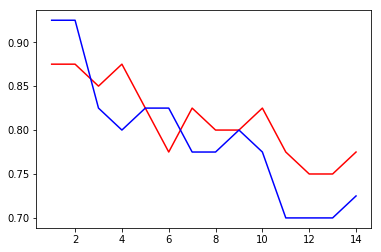

In [19]:
from sklearn.model_selection import train_test_split

x__train = x_train[0:200]
y__train = y_train[0:200]

X_train, X_test, Y_train, Y_test = train_test_split(x__train, y__train, test_size=0.2, stratify=y__train, random_state=0)

score_n3 = []
score_val = []
for k in np.arange(1, 15):
    clf = neighbors.KNeighborsClassifier(n_neighbors=k)
    clf.fit(X_train, Y_train)
    score_val.append(clf.score(X_test, Y_test))  
    
    clf_n3 = neighbors.KNeighborsClassifier(n_neighbors=k, metric = metric_n3)
    clf_n3.fit(X_train, Y_train)
    score_n3.append(clf_n3.score(X_test, Y_test))
    
plt.plot(np.arange(1, 15), score_n3, color='red')
plt.plot(np.arange(1, 15), score_val, color='blue')

print(np.max(score_val))
print(np.argmax(score_val)+1)
print(np.max(score_n3))
print(np.argmax(score_n3)+1)

## Algorithme partition binaire

Text(0.5,1,'Score silhouette en fonction de k')

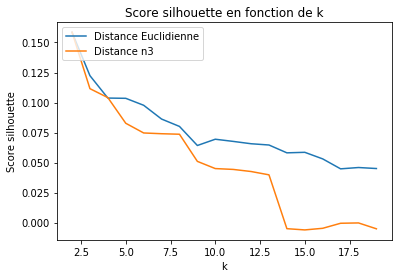

In [20]:
# Définie une matrice des distances avec la métrique de notre choix
m = pairwise_distances(x__test, metric=metric_n3)

scores = []
scores_t=[]
k_range = range(2,20)
for k in k_range:
    y_pred = AgglomerativeClustering(affinity='euclidean', linkage='average', n_clusters=k).fit_predict(x__test)
    scores.append(silhouette_score(x__test, y_pred))
    y_pred_t = AgglomerativeClustering(affinity='precomputed', linkage='average', n_clusters=k).fit_predict(m)
    scores_t.append(silhouette_score(x__test, y_pred_t))
plt.plot(k_range, scores, label='Distance Euclidienne')
plt.plot(k_range, scores_t, label='Distance n3')
plt.legend(loc='upper left')
plt.xlabel('k')
plt.ylabel('Score silhouette')
plt.title('Score silhouette en fonction de k')

## Algorithme PCoA

In [41]:
from pandas import DataFrame
from warnings import warn
import ecopy as ep

class pcoa(object):
	'''
	Docstring for function ecopy.pcoa
	====================
	Conducts principle coordinate analysis of a user-supplied
		distance matrix. Matrix must be square symmetric
	Use
	----
	pcoa(x, correction=None, siteNames=None)
	Returns an object of class pcoa
	Parameters
	----------
	x:  Data for ordination. Should be a pandas.DataFrame or
		numpy.ndarray square, symmetric matrix of distances.
		See ecopy.distance for calculation of distances.
		See online documentation for details about the
		method
	correction: Which correction for negative eigenvalues
		should be applied. Accepts either '1' or '2'. 
		See online documentation for details.
	siteNames: A list of site names used in biplots
	Attributes
	---------
	evals: Eigenvalues of the transformed distance matrix
	U: Eigenvectors of the transformed distance matrix.
		Each eigenvector has already been multiplied
		by the square root of its eigenvalue
	correction: The correction applied to correct for negative
		eigenvalues
	
	Methods
	--------
	summary(): Returns a pandas.DataFrame summary
		table of PCoA axes
	biplot(coords=False, xax=1, yax=2, descriptors=None, descripNames=None):
	   	Produces a biplot of given PCoA axes
	   	coords: If true, return coordinates for objects and descriptors for
	   		custom plotting
		xax: An integer specifying which PCoA axis should appear
			on the x-axis (Defaults to 1)
		yax: An integer specifying which PCoA axis should appear
			on the y-axis (Defaults to 2)
		descriptors: A pandas.DataFrame or numpy.ndarray
			of descriptors to project onto the biplot. Descriptors
			are all standardized prior to projection
		descripNames: A list of names for the descriptors. If
			not specified, will be taken from the column names
			if descriptors is a pandas.DataFrame
	shepard(xax=1, yax=2): Produces a shepard diagram
		plotting the euclidean distances in reduced space
		against observed distances from the original matrix
	
	Example
	--------
	import ecopy as ep
	BCI = ep.load_data('BCI')
	brayD = ep.distance(BCI, method='bray', transform='sqrt')
	pc1 = ep.pcoa(brayD)
	print(pc1.summary())
	pc1.biplot()
	pc1.shepard()
	'''
	def __init__(self, x, correction=None, siteNames=None):
		if not isinstance(x, (DataFrame, np.ndarray)):
			msg = 'Data must either be pandas.DataFrame or nump.ndarray'
			raise ValueError(msg)
		if isinstance(x, DataFrame):
			if (x.dtypes == 'object').any():
				msg = 'DataFrame can only contain numeric values'
				raise ValueError(msg)
			y = np.array(x)
		if isinstance(x, np.ndarray):
			y = x
		if np.isnan(y).any():
			msg = 'Distance matrix contains null values'
			raise ValueError(msg)
		if y.any() < 0:
			msg ='Distance matrix cannot contain negative values'
			raise ValueError(msg)
		if y.shape[0] != y.shape[1]:
			msg = 'Distance matrix must be square'
			raise ValueError(msg)
		if not np.allclose(y.T, y):
			msg ='Distance matrix must be symmetric'
			raise ValueError(msg)
		A = -0.5*np.square(y.astype('float'))
		n = y.shape[0]
		ones = np.ones(n)[np.newaxis].T
		I = np.eye(n)
		D = (I - ones.dot(ones.T)/n).dot(A).dot(I - ones.dot(ones.T)/n)
		self.evals, self.U = np.linalg.eig(D)
		self.evals = self.evals.real
		self.U = self.U.real
		idx = self.evals.argsort()[::-1]
		self.U = self.U[:,idx]
		if correction is not None:
			if correction not in ['1', '2']:
				msg = "correction must be either '1' or '2'"
				raise ValueError(msg)
		if correction is '1':
			negEvl = np.abs(np.min(self.evals[self.evals < 0]))
			A = -0.5*np.square(y) - negEvl
			np.fill_diagonal(A, 0)
			D = (I - ones.dot(ones.T)/n).dot(A).dot(I - ones.dot(ones.T)/n)
			self.evals, self.U = np.linalg.eig(D)
			idx = self.evals.argsort()[::-1]
			self.U = self.U[:,idx]
			self.correction = negEvl
		if correction is '2':
			mat0 = np.zeros((n,n))
			matI = -1.*np.eye(n)
			d1 = 2.*D
			d2 = -0.5*y
			d2 = -4.*(I - ones.dot(ones.T)/n).dot(d2).dot(I - ones.dot(ones.T)/n)
			t1 = np.concatenate((mat0, matI), axis=0)
			t2 = np.concatenate((d1, d2), axis=0)
			specMat = np.concatenate((t1, t2), axis=1)
			t_evals, t_evecs =np.linalg.eig(specMat)
			posEvl = np.max(np.real(t_evals))
			A = -0.5*(np.square(y.astype('float') + posEvl))
			np.fill_diagonal(A, 0)
			D = (I - ones.dot(ones.T)/n).dot(A).dot(I - ones.dot(ones.T)/n)
			self.evals, self.U = np.linalg.eig(D)
			idx = self.evals.argsort()[::-1]
			self.U = self.U[:,idx]
			self.correction = posEvl
		self.evals = np.round(self.evals[idx], 4)
		self.U = np.round(self.U.dot(np.diag(np.sqrt(self.evals))), 4)
		self.siteLabs = ['Site ' + str(x) for x in range(1, y.shape[0]+1)]
		if isinstance(x, DataFrame):
			self.siteLabs = x.index
		if siteNames is not None:
			self.siteLabs = siteNames
		self.y2 = y

	def summary(self):
		sds = np.sqrt(self.evals)
		props = self.evals / np.sum(self.evals)
		cumSums = np.cumsum(self.evals) / np.sum(self.evals)
		colNames = ['PCoA Axis ' + str(x) for x in range(1, len(self.evals)+1)]
		sumTable = DataFrame(np.vstack((sds, props, cumSums)), index=['Std. Dev', 'Prop.', 'Cum. Prop.'])
		sumTable.columns = colNames
		return sumTable
		
	def biplot(self, coords=False, xax=1, yax=2, descriptors=None, descripNames=None, spCol='r', siteCol='k', spSize=12, siteSize=12):
		if descriptors is not None:
				warn('\nWarning: Descriptors must not be binary.\nIgnore this message if all descriptors are quantitative\n')
				if not isinstance(descriptors, (DataFrame, np.ndarray)):
					msg = 'descriptors must be a pandas.DataFrame or numpy.ndarray'
					raise ValueError(msg)				
				if isinstance(descriptors, DataFrame):
					if (descriptors.dtypes == 'object').any():
						msg = 'DataFrame can only contain numeric values'
						raise ValueError(msg)
				d2 = np.array(descriptors)
				d2 = np.apply_along_axis(lambda x: (x - np.mean(x))/np.std(x, ddof=1), 0, d2)
				if isinstance(descriptors, DataFrame):
					dLabs = descriptors.columns.values
				elif descripNames is not None:
					if len(descripNames) != d2.shape[1]:
						msg = 'descripNames must be equal to the number of columns in descriptors'
						raise ValueError(msg)
					dLabs = descripNames
				else:
					dLabs = ['D'+str(x) for x in range(1, d2.shape[1] + 1)]
				U2 = self.U[:,[xax-1, yax-1]].astype('float')
				U2 = np.apply_along_axis(lambda x: (x - np.mean(x))/np.std(x, ddof=1), 0, U2)
				S = (1./(d2.shape[0]-1))*d2.T.dot(U2)
				dProj = np.sqrt(d2.shape[0]-1)*S.dot(np.diag(self.evals[[xax-1, yax-2]]**-0.5))
		if not coords:
			f, ax = py.subplots()
			ax.axvline(0, ls='solid', c='k')
			ax.axhline(0, ls='solid', c='k')
			ax.plot(self.U[:,xax-1], self.U[:,yax-1], 'ko', ms=0)
			[ax.text(x,y,s, color=siteCol, fontsize=siteSize, ha='center', va='center') for x,y,s in zip(self.U[:,xax-1], self.U[:,yax-1], self.siteLabs)]
			if descriptors is not None:
				ax.plot(dProj[:,0], dProj[:,1], 'ko', ms=0)
				[ax.text(x,y,s, color=spCol, fontsize=spSize, ha='center', va='center') for x,y,s in zip(dProj[:,0], dProj[:,1], dLabs)]
			ax.set_xlabel('PCoA Axis {!s}'.format(xax))
			ax.set_ylabel('PCoA Axis {!s}'.format(yax))
			py.show()
		else:
			if descriptors is not None:
				return {'Objects': self.U[:,[xax-1, yax-1]], 'Descriptors': dProj}
			else:
				return {'Objects': self.U[:,[xax-1, yax-1]]}

	def shepard(self, xax=1, yax=2):
		coords = self.U[:,[xax-1, yax-1]]
		reducedD = np.zeros((coords.shape[0], coords.shape[0]))
		for i in xrange(coords.shape[0]):
			for j in xrange(coords.shape[0]):
				d = coords[i,:] - coords[j,:]
				reducedD[i, j] = np.sqrt( d.dot(d) )
		reducedD = reducedD[np.tril_indices_from(reducedD, k=-1)]
		originalD = self.y2[np.tril_indices_from(self.y2, k=-1)]
		xmin = np.min(reducedD)
		xmax = np.max(reducedD)
		f, ax = py.subplots()
		ax.plot(reducedD, originalD, 'ko')
		ax.plot([xmin, xmax], [xmin, xmax], 'r--')
		ax.set_xlabel('Distances in Reduced Space')
		ax.set_ylabel('Distances in Original Matrix')
		py.show()


ModuleNotFoundError: No module named 'ecopy'

(50, 676) (50,)
(50, 676) (50,)
(50, 676) (50,)
(50, 676) (50,)
(50, 676) (50,)
(50, 676) (50,)


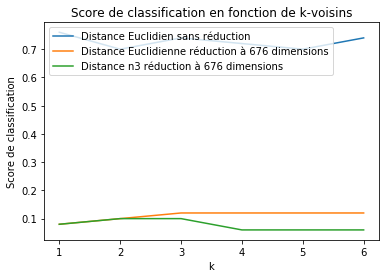

In [38]:
from sklearn.manifold import MDS
from sklearn.decomposition import PCA
#X_transformedEuc =MDS(n_components=2,n_init=2).fit_transform(x__test)

#X_transformed =MDS(n_components=2,n_init=2,dissimilarity='precomputed').fit_transform(m)

#fig1 = plt.figure()
#ax2 = fig1.add_subplot(111) 
#ax2.set_title('PCoA avec notre propre Distance')
#ax2.scatter(X_transformed[:,0],X_transformed[:,1] , c=y__test, alpha=1)
#plt.show

#fig = plt.figure()  
#ax1 = fig.add_subplot(111) 
#ax1.set_title('PCoA avec Distance Euclidienne')
#ax1.scatter(X_transformedEuc[:,0],X_transformedEuc[:,1] , c=y__test, alpha=1)
#plt.show
x__train = x_train[0:200]
y__train = y_train[0:200]
x__test= x_test[0:50]
y__test = y_test[0:50]

dimensions = [676]

for dim in dimensions :
    # Reduction de dimension des échantillons "train"
    x_train_reducedEuc     = pcoa(0.95).fit_transform(x__train)
    matrix_train = pairwise_distances(x__train, metric=metric_n3)
    x_train_reducedMetric3 = MDS(n_components=dim,n_init=4,dissimilarity='precomputed').fit_transform(matrix_train)

    # Reduction de dimension des échantillons "test"
    x_test_reducedEuc     = PCA(0.95).fit_transform(x__test)
    matrix_test = pairwise_distances(x__test, metric=metric_n3)
    x_test_reducedMetric3 = MDS(n_components=dim,n_init=4,dissimilarity='precomputed').fit_transform(matrix_test)
    
    scoreNoReduction = []
    scoreEuc = []
    scoreN3  = []
    k_range = np.arange(1,7)
    for k in k_range:

        # Classification KNN Euclidien sans réduction
        knn = neighbors.KNeighborsClassifier(n_neighbors=k)
        knn.fit(x__train, y__train)
        scoreNoReduction.append(knn.score(x__test, y__test)) 


        # Classification KNN pour Euclidien
        knn = neighbors.KNeighborsClassifier(n_neighbors=k)
        knn.fit(x_train_reducedEuc, y__train)
        print((np.array(x_test_reducedEuc)).shape, (np.array(y__test)).shape)
        scoreEuc.append(knn.score(x_test_reducedEuc, y__test)) 

        # Classification KNN pour Metric3
        knn = neighbors.KNeighborsClassifier(n_neighbors=k)
        knn.fit(x_train_reducedMetric3, y__train)
        scoreN3.append(knn.score(x_test_reducedMetric3, y__test))

    # Affichage
    plt.figure()
    plt.plot(k_range, scoreNoReduction , label='Distance Euclidien sans réduction')
    plt.plot(k_range, scoreEuc, label=('Distance Euclidienne réduction à '+ str(dim) + ' dimensions'))
    plt.plot(k_range, scoreN3, label=('Distance n3 réduction à '+ str(dim) + ' dimensions'))
    plt.legend(loc='upper left')
    plt.xlabel('k')
    plt.ylabel('Score de classification')
    plt.title('Score de classification en fonction de k-voisins')


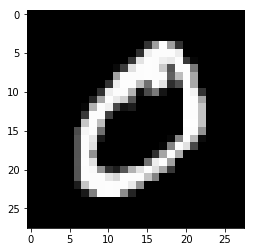

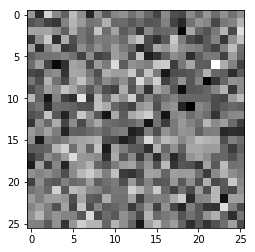

In [34]:
matrix = np.reshape(x__train[1], (28,28))
plt.figure()
plt.imshow(matrix, cmap='gray')

matrix = np.reshape(x_train_reducedEuc[1], (26,26))
plt.figure()
plt.imshow(matrix, cmap='gray')

## Algorithme Isomap

Algorithme Isomap avec notre propre notation de similatrité et visualiser en 2D

<function matplotlib.pyplot.show(*args, **kw)>

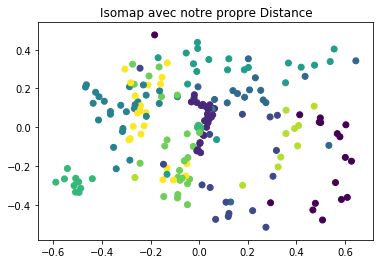

In [8]:
from sklearn.neighbors import NearestNeighbors, kneighbors_graph,KNeighborsClassifier
from sklearn.manifold import MDS
from sklearn.utils.graph import graph_shortest_path
from matplotlib.pyplot import scatter

 #isomap avec notre distance propre x:donée k:n_neighbors n:n_components
def myIsomap(x,k,n):
    kng = kneighbors_graph(x,n_neighbors=k, mode='distance',metric=metric_n3)
    #caculer le plus court chemin
    distmatrix = graph_shortest_path(kng,directed=False,method ='D')
    isomap=MDS(n_components=n,dissimilarity='precomputed')
    #isomap avec notre distance propre
    X_transformed = isomap.fit_transform(distmatrix)
    return X_transformed
x = x_test[0:200]
X_transformed = myIsomap(x,3,2) 
y=y_test[0:200]
fig1 = plt.figure()  
ax2 = fig1.add_subplot(111) 
ax2.set_title('Isomap avec notre propre Distance')
ax2.scatter(X_transformed[:,0],X_transformed[:,1] , c=y, alpha=1)
plt.show



Algorithme Isomap avec Distance Euclidienne et visualiser en 2D

<function matplotlib.pyplot.show(*args, **kw)>

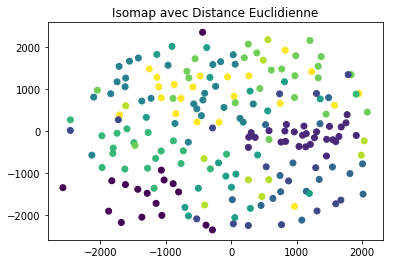

In [9]:
mds=MDS(n_components=2)
X_transformedEuc=mds.fit_transform(x)

y=y_test[0:200]
fig = plt.figure()  
ax1 = fig.add_subplot(111) 
ax1.set_title('Isomap avec Distance Euclidienne')
ax1.scatter(X_transformedEuc[:,0],X_transformedEuc[:,1] , c=y, alpha=1)
plt.show

comparer les deux figure ,la reduction dementionalité avec isomap de notre propre similarité est mieux.Car les point de même class sont plus proches que ceaux obtenus par isomap avec distance Euclidienne

 Comparer le performance  en utilisant knn classification avec différent k(nombre de voisin)et différent n (nombre de composant)

In [10]:
#préparer des donnéé
xtest = x_test[0:50]
y__test = y_test[0:50]
x__train = x_train[0:300]
y__train = y_train[0:300]
#compresser x__train avec isomap Euclidienne
for n in range(50,300,50): 
    print(n)
    mds = MDS(n_components=k)
    x__trainNew = mds.fit_transform(x__train)
    knn = KNeighborsClassifier()
    knn.fit(x__trainNew,y__train)
    x__testNew = mds.fit_transform(xtest)

   #évaluer le performance
    print("score de isomap avec distance Euclidienne:",knn.score(x__testNew,y__test))

#compresser x__train avec isomap notre distance,utiliser diffirent n
    x__MytrainNew = myIsomap(x__train,5,100)
    x__MytestNew = myIsomap(xtest,5,100)
    knn = KNeighborsClassifier()
    knn.fit(x__MytrainNew,y__train)

#évaluer le performance

    print("score de isomap avec notre distance :",knn.score(x__MytestNew,y__test))


50
score de isomap avec distance Euclidienne: 0.0
score de isomap avec notre distance : 0.04
100
score de isomap avec distance Euclidienne: 0.08
score de isomap avec notre distance : 0.02
150
score de isomap avec distance Euclidienne: 0.04
score de isomap avec notre distance : 0.2
200
score de isomap avec distance Euclidienne: 0.1
score de isomap avec notre distance : 0.18
250
score de isomap avec distance Euclidienne: 0.06
score de isomap avec notre distance : 0.0


In [ ]:
#préparer des donnéé
xtest = x_test[0:50]
y__test = y_test[0:50]
x__train = x_train[0:300]
y__train = y_train[0:300]
#compresser x__train avec isomap Euclidienne
mds = MDS(n_components=300)
x__trainNew = mds.fit_transform(x__train)
knn = KNeighborsClassifier()
knn.fit(x__trainNew,y__train)
x__testNew = mds.fit_transform(xtest)

#évaluer le performance
print("score de isomap avec distance Euclidienne:",knn.score(x__testNew,y__test))

#compresser x__train avec isomap notre distance,utiliser diffirent k
for k in range(1,10):
    print("k:",k)
    x__MytrainNew = myIsomap(x__train,k,300)
    x__MytestNew = myIsomap(xtest,k,300)
    knn = KNeighborsClassifier()
    knn.fit(x__MytrainNew,y__train)

#évaluer le performance
    print("score de isomap avec notre distance :",knn.score(x__MytestNew,y__test))


score de isomap avec distance Euclidienne: 0.12
k: 1
score de isomap avec notre distance : 0.18
k: 2
score de isomap avec notre distance : 0.18
k: 3
score de isomap avec notre distance : 0.18
k: 4
score de isomap avec notre distance : 0.18
k: 5
score de isomap avec notre distance : 0.3
k: 6


utiliser le donnée compressée avec isomap en utilisant deux notion de similatité ,pour classiffier avec knn,après comparer le taux de success ,notre notion de similarité n'est pas toujours mieux que distance Euclidienne ,ça depend aussi les hyperparamètres,mais la plupart de temps notre notion de similarité est meilleure que distance Euclidienne .

Comparer le performance  en utilisant cross_validation

In [ ]:
from sklearn.model_selection import cross_val_score

x = x_test[0:1000]

#compresser x__train avec isomap Euclidienne
mds = MDS(n_components=300)
x__trainNew = mds.fit_transform(x__train)
knn = KNeighborsClassifier()
knn.fit(x__trainNew,y__train)
x__testNew = mds.fit_transform(xtest)
#evaluer le performance
scoresMds = cross_val_score(knn, x__trainNew,y__train, cv=5,scoring='accuracy')
print("score moyenne de isomap avec Euclidienne::",scoresMds.mean())

#compresser x__train avec isomap notre distance
x__MytrainNew = myIsomap(x__train,k,300)
x__MytestNew = myIsomap(xtest,k,300)
knn = KNeighborsClassifier()
knn.fit(x__MytrainNew,y__train)
scoresMyIsomap = cross_val_score(knn, x__MytrainNew,y__train, cv=5,scoring='accuracy')
print("score moyenne de isomap avec notre propre distance::",scoresMyIsomap.mean())

voila seulons cross-validation notre notion est mieux.

comparer en utilisant silhouette score

In [ ]:


x = x_test[0:100]
scores = []
scores_t=[]
k_range = range(2,20,3)

for k in k_range:
    
    X_transformed = myIsomap(x,k,300)
    
    #isomp avec euclidean
    mds=MDS(n_components=300)
    X_transformedEuc=mds.fit_transform(x)
    
    
    y_pred = KMeans(n_clusters=5).fit_predict( X_transformed )
    scores.append(silhouette_score(x, y_pred))
    
    y_pred_t = KMeans(n_clusters=5).fit_predict(X_transformedEuc )
    scores_t.append(silhouette_score(x, y_pred_t))
    


plt.plot(k_range, scores, label='Distance propre (isomap)')
plt.plot(k_range, scores_t, label='Distance Euclidienne (isomap')

plt.legend(loc='upper left')
plt.xlabel('k')
plt.ylabel('Score silhouette')
plt.title('Score silhouette en fonction de k')

conclusion:notre notation de similarité utiise dans Isomap, la pluspart de temps est mieux que distance Euclidienne.